In [65]:
import numpy as np

n_stars = 3000

tallness = 1 #galaxy sim shennanigans

def generate_points_sphere(n_points, radius=1.0, offset=(0,0,0)):
    points = []
    while len(points) < n_points:
        x, y, z = np.random.uniform(-radius, radius, 3)
        if x**2 + y**2 + z**2 <= radius**2:
            points.append([x+offset[0], y+offset[1], z*tallness+offset[2]])
    return points

pos_data = np.array(generate_points_sphere(n_stars, 1.0, offset=(0, 0.25, 0.25)))
print(pos_data.shape)
pos_data.T.tofile('positions.dat')


def generate_velocity(pos_data, omega_z=1):
    x, y, z = pos_data[:, 0], pos_data[:, 1], pos_data[:, 2]
    
    vx = -omega_z * y
    vy = omega_z * x
    vz = np.zeros_like(z)  
    
    velocities = np.column_stack((vx, vy, vz))
    
    return velocities

vel_data = generate_velocity(pos_data)
vel_data.T.tofile('velocities.dat')

(3000, 3)


# Compile and run 

In [68]:
import os

ST_source = 'src/ST_src.f90'
ST_flags = '-O3'
ST_compile = f'gfortran {ST_flags} -o bin/ST_out.o {ST_source}'


MT_source = 'src/MT_src.f90'
MT_flags = '-O3'
MT_compile = f'gfortran {MT_flags} -fopenmp -o bin/MT_out.o {MT_source}'

print(ST_compile)
os.system(ST_compile)

print(MT_compile)
os.system(MT_compile)


#Run ST
os.system("bin/ST_out.o")


#Set and run MT
env_var = [
    ["OMP_NUM_THREADS", str(10)],
    ["OMP_SCHEDULE", f'dynamic,50']
]
for i in env_var:
    os.environ[i[0]] = i[1]

os.system("bin/MT_out.o")


gfortran -O3 -o bin/ST_out.o src/ST_src.f90
gfortran -O3 -fopenmp -o bin/MT_out.o src/MT_src.f90


1

# Exploit

Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
Time step: 20
Time step: 21
Time step: 22
Time step: 23
Time step: 24
Time step: 25
Time step: 26
Time step: 27
Time step: 28
Time step: 29
Time step: 30
Time step: 31
Time step: 32
Time step: 33
Time step: 34
Time step: 35
Time step: 36
Time step: 37
Time step: 38
Time step: 39
Time step: 40
Time step: 41
Time step: 42
Time step: 43
Time step: 44
Time step: 45
Time step: 46
Time step: 47
Time step: 48
Time step: 49
Time step: 50
Time step: 51
Time step: 52
Time step: 53
Time step: 54
Time step: 55
Time step: 56
Time step: 57
Time step: 58
Time step: 59
Time step: 60
Time step: 61
Time step: 62
Time step: 63
Time step: 64
Time step: 65
Time step: 66
Time step: 67
Time step: 68
Time step: 69
Time step: 70
Time step: 71
Ti

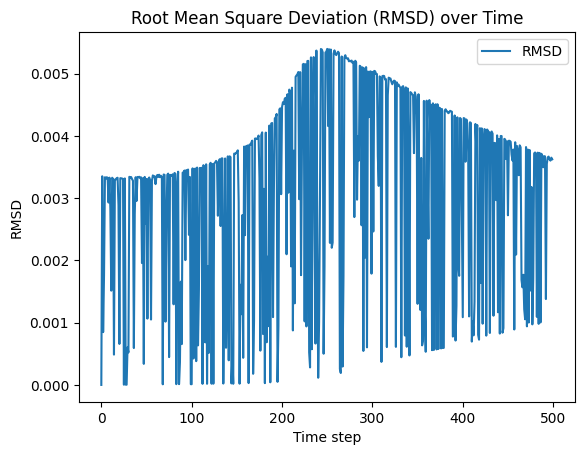

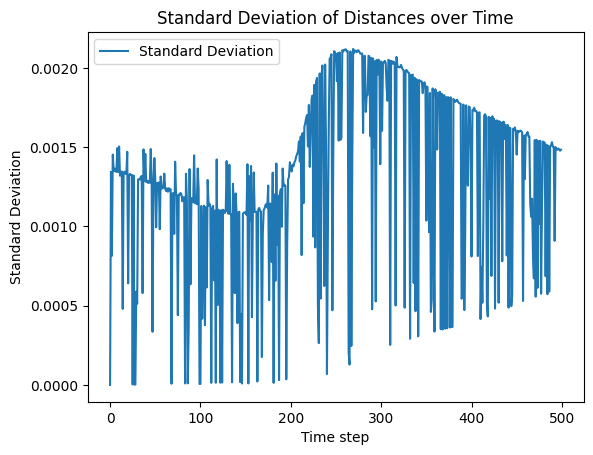

In [86]:
def load_file_unformatted(filename: str, nbline: int = 0, timestep: int = -1, param: list = []):
    with open(filename, "rb") as file:
        if timestep == -1:
            # Read the first 3 integers of the file (metadata)
            record_size = np.fromfile(file, dtype=np.int32, count=1)  # Skip record size marker
            metadata = np.fromfile(file, dtype=np.int32, count=3)    # Read metadata
            record_size = np.fromfile(file, dtype=np.int32, count=1)  # Skip end record marker
            return metadata
        else:
            # Validate 'param'
            if param is None or len(param) < 3:
                raise ValueError("Parameter list 'param' must include [num_particles, num_timesteps, float_precision].")
            
            num_particles, num_timesteps, float_precision = param
            dtype = np.float32 if float_precision == 4 else np.float64
            record_bytes = 4 + (num_particles * 3 * dtype().nbytes) + 4
            
            # Skip records before the desired timestep
            file.seek(4 + (record_bytes * timestep), 0)  # 4 bytes for record size + N records
            
            # Read the data for the timestep
            _ = np.fromfile(file, dtype=np.int32, count=1)  # Skip record size marker
            data = np.fromfile(file, dtype=dtype, count=num_particles * 3)  # Read positions
            _ = np.fromfile(file, dtype=np.int32, count=1)  # Skip end record marker
            
            # Reshape data into (3, nbline) format (x, y, z)
            # data = data.reshape(nbline, 3).T
            data = data.reshape(3, nbline)
            return data



file_ST = "ST_position.dat"
file_MT = "MT_position.dat"
mean_dist = []
max_dist = []
min_dist = []

mean_perc = []
max_perc = []
min_perc = []

import math
import matplotlib.pyplot as plt

param = [n_stars, 500, 8]


import math
import numpy as np

rmsd_list = []  # List to store RMSD at each time step
sd_list = []    # List to store standard deviation at each time step

# For each time step
for t in range(500):
    print(f"Time step: {t}")
    
    st_pos = load_file_unformatted(file_ST, param[0], t, param)
    mt_pos = load_file_unformatted(file_MT, param[0], t, param)

    # Initialize lists to store distances for RMSD and SD
    dists = []

    for i in range(len(st_pos[0])):
        x1, y1, z1 = st_pos[0][i], st_pos[1][i], st_pos[2][i]
        x2, y2, z2 = mt_pos[0][i], mt_pos[1][i], mt_pos[2][i]

        # Calculate the Euclidean distance between corresponding particles
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        dists.append(dist)

    # Calculate RMSD for the current time step
    rmsd = math.sqrt(np.mean(np.square(dists)))
    rmsd_list.append(rmsd)

    # Calculate the standard deviation (SD) for the current time step
    sd = np.std(dists)
    sd_list.append(sd)

# Now, you can plot the RMSD and SD over time
plt.plot(rmsd_list, label="RMSD")
plt.title("Root Mean Square Deviation (RMSD) over Time")
plt.xlabel("Time step")
plt.ylabel("RMSD")
plt.legend()
plt.show()

plt.plot(sd_list, label="Standard Deviation")
plt.title("Standard Deviation of Distances over Time")
plt.xlabel("Time step")
plt.ylabel("Standard Deviation")
plt.legend()
plt.show()


# Energy check

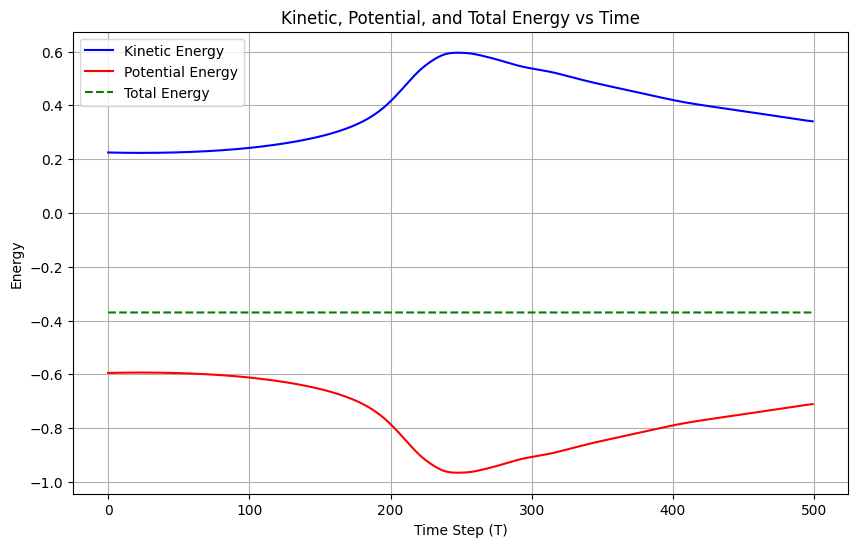

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the file
data = np.loadtxt('energy.dat')

# Extract kinetic and potential energy from the columns
potential_energy = data[:, 0]
kinetic_energy = data[:, 1]

# Calculate the total energy (kinetic + potential)
total_energy = kinetic_energy + potential_energy

# Create a plot
plt.figure(figsize=(10, 6))

# Plot kinetic energy
plt.plot(kinetic_energy, label='Kinetic Energy', color='blue')

# Plot potential energy
plt.plot(potential_energy, label='Potential Energy', color='red')

# Plot total energy
plt.plot(total_energy, label='Total Energy', color='green', linestyle='--')

# Add labels and title
plt.xlabel('Time Step (T)')
plt.ylabel('Energy')
plt.title('Kinetic, Potential, and Total Energy vs Time')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
